In [1]:
import sys
import os
import glob
import functools
from datetime import datetime
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib.cm import viridis
import multiprocessing as mp
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

### Low level functions

In [2]:
base_path = '/mnt/sdb/ag_viz/Agriculture-Vision/'

In [3]:
label_dict = {0: 'background', 
              1: 'cloud_shadow', 
              2: 'double_plant', 
              3: 'planter_skip', 
              4: 'standing_water',
              5: 'waterway', 
              6: 'weed_cluster'}

In [4]:
def build_folder_paths(base_path, data_category):
    path_dict = {}
    path_home = os.path.join(base_path,data_category)
    path_dict['rgb'] = os.path.join(path_home, 'images/rgb')
    path_dict['nir'] = os.path.join(path_home, 'images/nir')
    path_dict['boundary'] = os.path.join(path_home, 'boundaries')
    path_dict['mask'] = os.path.join(path_home, 'masks')

    if data_category != 'test':
        for k,v in label_dict.items():
            if k != 0:
                path_dict[f'labels_{k}'] = os.path.join(path_home, 'labels/' + v)
    
    return path_dict

In [5]:
def get_file_paths(file_name, folder_dict):
    file_dict = {}
    
    for k,v in folder_dict.items():
        file_i = glob.glob(os.path.join(v, file_name + '*'))[0]
        file_dict[k] = file_i

    return file_dict
def get_file_paths_list(file_name, folder_dict):
    file_list = []
    
    for v in folder_dict.values():
        file_i = glob.glob(os.path.join(v, file_name + '*'))[0]
        file_list.append(file_i)

    return file_list

### Reading in images

In [6]:
def read_in_all_images(row_info):
    image_info = {}
    for k,v in row_info.items():
        image_info[k] = np.array(Image.open(v))
        
    return image_info

def read_in_image(row_info, image_type):
    return np.array(Image.open(row_info[image_type]))

### Functions for sampling of images

In [7]:
def parallel_image_info(image_name, image_type, folder_dict):
    file_info = get_file_paths(image_name, folder_dict)
    return read_in_image(file_info, image_type)

def parallel_all_image_info(image_name, folder_dict):
    file_info = get_file_paths(image_name, folder_dict)
    return read_in_all_images(file_info)

In [8]:
def get_random_many_images(width, height, image_names, image_type, folder_dict):
    num = width * height
    rand_image_names = np.random.choice(image_names, num, replace = False)
    
    with mp.Pool(processes = mp.cpu_count() - 1) as pool:
        images = pool.map(functools.partial(parallel_image_info, 
                                            image_type = image_type, 
                                            folder_dict = folder_dict), 
                          list(rand_image_names))
    
    fig, axes = plt.subplots(height, width, figsize=(20,16))
    for i,ax in enumerate(axes.flat):
        im = ax.imshow(images[i], vmin = 0, vmax = 255)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

In [9]:
def get_random_single_image(rows, image_names, folder_dict, plot = True):
    rand_image_names = np.random.choice(image_names, rows, replace = False)
    
    with mp.Pool(processes = mp.cpu_count() - 1) as pool:
        images = pool.map(functools.partial(parallel_all_image_info, 
                                            folder_dict = folder_dict), 
                          list(rand_image_names))
    
    if plot == True:
        key_order = list(images[0].keys())

        fig, axes = plt.subplots(rows, len(images[0]), figsize=(20,16))
        for i,ax in enumerate(axes.flat):
            image_type = key_order[i % len(images[0])]
            if image_type.find('label') != -1:
                image_type_title = label_dict[int(image_type[-1])]
            else:
                image_type_title = image_type
            if i // 10 == 0:
                ax.set_title(image_type_title, fontdict = {'fontsize' : 18})
            ax.imshow(images[i // 10][image_type], cmap = viridis, vmin = 0, vmax = 255)
    elif plot == False:
        return images

### Looking at some images

In [10]:
folder_dict = build_folder_paths(base_path, 'train')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]

In [13]:
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)

In [14]:
file_info = get_file_paths(list_image_names[0], folder_dict)
image_info = read_in_all_images(file_info)

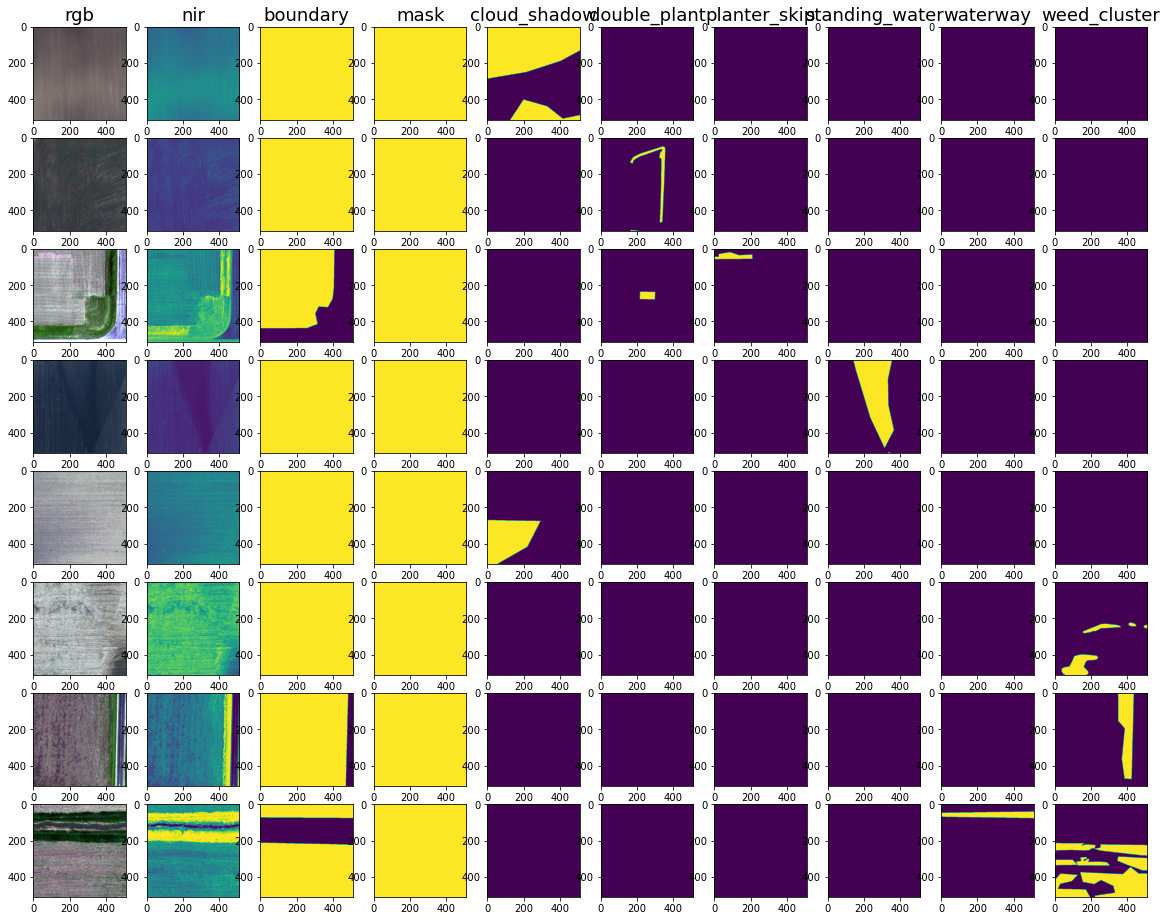

In [15]:
#results = get_random_single_image(10, list_image_names, folder_dict, plot = False)
get_random_single_image(8, list_image_names, folder_dict, plot = True)

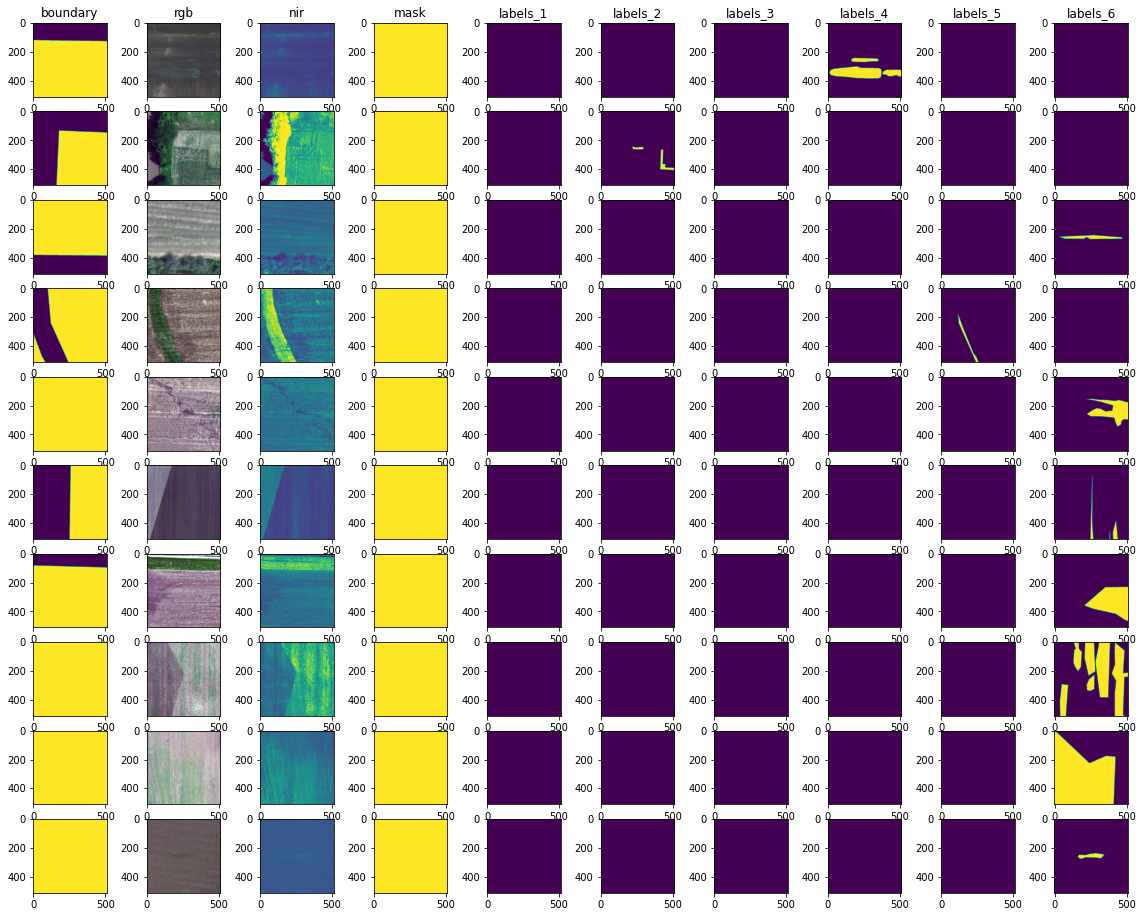

In [223]:
get_random_single_image(10, list_image_names, folder_dict, plot = True)

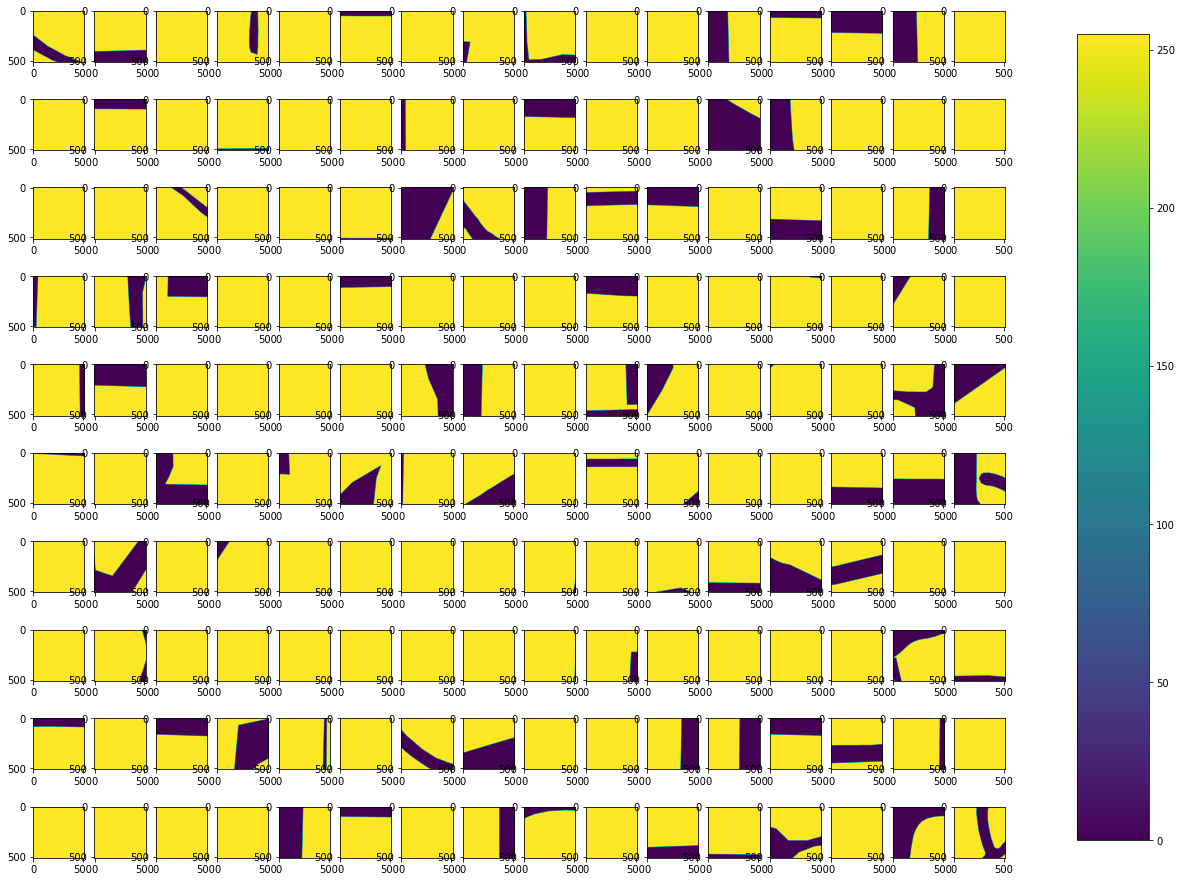

In [220]:
get_random_many_images(16, 10, list_image_names, 'boundary', folder_dict)

### Process data into TF

In [11]:
file_info

NameError: name 'file_info' is not defined

In [10]:
# Sourced from challenge winner - https://github.com/th2l/Agriculture-Vision-Segmentation/blob/master/main.py
def gpu_process_image_dev(file_info, folder_dict):
    folder_names = {x:i for i,x in enumerate(list(folder_dict.keys()))}
    # Read RGB
    rgb_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['rgb']]), channels=3)

    # Read NIR
    nir_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['nir']]), channels=1)

    # Concat rgb and nir to NRGB
    nrgb_image = tf.concat([nir_image, rgb_image], axis=2)  # 512 x 512 x 4

    # Read boundary
    bdr_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['boundary']]), channels=1)

    # Read mask
    msk_image = tf.image.decode_image(tf.io.read_file(file_info[folder_names['mask']]), channels=1)

    invalid_pixels = tf.logical_or(bdr_image == 0, msk_image == 0)

    nrgb_image = tf.where(invalid_pixels, tf.zeros_like(nrgb_image), nrgb_image)
    nrgb_image = tf.image.convert_image_dtype(nrgb_image, tf.float32)
    
    ld_labels = {0: tf.identity(invalid_pixels)}
    
    for idx in range(1, len(label_dict)):
        # Read label
        current_label = tf.image.decode_image(tf.io.read_file(file_info[folder_names[f'labels_{idx}']]), channels=1)

        ld_labels[idx] = tf.logical_and(current_label > 0, tf.logical_not(invalid_pixels))
        ld_labels[0] = tf.logical_or(ld_labels[idx], ld_labels[0])
        

    ld_labels[0] = tf.logical_not(ld_labels[0])

    ret_label = tf.cast(tf.concat(
        [ld_labels[0], ld_labels[1], ld_labels[2], ld_labels[3], ld_labels[4], ld_labels[5], ld_labels[6],
        invalid_pixels], axis=2), dtype=tf.int32)  # 512 x 512 x 8

    nrgb_image.set_shape((512, 512, 4))
    ret_label.set_shape((512, 512, 8))

    return nrgb_image, ret_label


In [11]:
folder_dict = build_folder_paths(base_path, 'train')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]

In [12]:
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)
    

In [58]:
process_train = lambda x: gpu_process_image_dev(x, folder_dict = folder_dict)
train_ds = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_train)
            .batch(4)
            .repeat()
            .prefetch(4))

In [59]:
folder_dict = build_folder_paths(base_path, 'val')
list_image_names = [x[:-4] for x in os.listdir(folder_dict['rgb'])]
with mp.Pool(processes = mp.cpu_count() - 1) as pool:
    file_locations = pool.map(functools.partial(get_file_paths_list, folder_dict = folder_dict), list_image_names)

In [60]:
process_val = lambda x: gpu_process_image_dev(x, folder_dict = folder_dict)
val_ds = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_val)
            .batch(4)
            .repeat()
            .prefetch(4))

In [61]:
val_ds_final = (tf.data.Dataset.from_tensor_slices(np.array(file_locations))
            .map(process_val)
            .batch(4))

In [62]:
print('train data: ' + str(train_ds))
print('validation data: ' + str(val_ds))

train data: <PrefetchDataset shapes: ((None, 512, 512, 4), (None, 512, 512, 8)), types: (tf.float32, tf.int32)>
validation data: <PrefetchDataset shapes: ((None, 512, 512, 4), (None, 512, 512, 8)), types: (tf.float32, tf.int32)>


### Model Preparation

In [63]:
encoder = tfk.Sequential([
  tfkl.InputLayer((512,512,4)),
  tfkl.Conv2D(256, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.MaxPooling2D((2,2), padding = 'same'),
  tfkl.Dropout(0.05), 
])
encoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 512, 512, 256)     9472      
_________________________________________________________________
batch_normalization_41 (Batc (None, 512, 512, 256)     1024      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 256, 256, 256)     0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 256, 256, 128)     295040    
_________________________________________________________________
batch_normalization_42 (Batc (None, 256, 256, 128)     512       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 128)   

In [64]:
decoder = tfk.Sequential([
  tfkl.InputLayer(encoder.output.shape[1:]),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.UpSampling2D((2,2)),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(8, (3,3), activation = 'relu', padding = 'same')
])
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 128, 128, 64)    

In [65]:
nir_model = tfk.Sequential([
  tfkl.InputLayer((512,512,1)),
  tfkl.Conv2D(32, (2,2), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.AveragePooling2D((4,4), padding = 'same'),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.AveragePooling2D((4,4), padding = 'same'),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(8, (3,3), activation = 'relu', padding = 'same'),
  tfkl.UpSampling2D((4,4)),
  tfkl.Dropout(0.05),
  tfkl.Conv2D(8, (3,3), activation = 'relu', padding = 'same'),
  tfkl.BatchNormalization(),
  tfkl.UpSampling2D((4,4)),
])
nir_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 512, 512, 32)      160       
_________________________________________________________________
batch_normalization_49 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
average_pooling2d_6 (Average (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_50 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
average_pooling2d_7 (Average (None, 32, 32, 32)      

In [66]:
x = tfkl.Input((512,512,4))
nir_output = nir_model(x[:,:,:,0:1])
h = encoder(x)
y_all = decoder(h)

In [67]:
combined_layer = tfkl.concatenate(inputs = [y_all, nir_output], axis = -1)
final_layer = tfkl.Conv2D(8, (3,3), activation = 'sigmoid', padding = 'same')(combined_layer)
final_layer

<tf.Tensor 'conv2d_63/Sigmoid:0' shape=(None, 512, 512, 8) dtype=float32>

In [68]:
multi_predictor = tfk.Model(inputs=x, outputs=final_layer)
multi_predictor.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 512, 512, 4) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 32, 32, 32)   398688      input_18[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 512, 512, 1) 0           input_18[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 512, 512, 8)  181160      sequential_11[0][0]              
_______________________________________________________________________________________

In [69]:
class AgrVimIOU(tf.keras.metrics.Metric):
    """ Modified mIOU as in Agriculture-Vision challenge 
        Sourced from: https://github.com/th2l/Agriculture-Vision-Segmentation
    """
    def __init__(self, name='AgrVimIOU', num_classes=7, per_classes=False):
        super(AgrVimIOU, self).__init__(name=name)
        self.num_classes = num_classes
        self.arr_mult = tf.range(1, self.num_classes + 1, dtype=tf.float32)

        self.total_true_positive = self.add_weight(
            'total_true_positive',
            shape=(self.num_classes,),
            initializer=tf.zeros_initializer,
            dtype=tf.float64)

        self.total_union = self.add_weight(
            'total_union',
            shape=(self.num_classes,),
            initializer=tf.zeros_initializer,
            dtype=tf.float64)
        self.per_classes = per_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        :param y_true: batch_size x 512 x 512 x 8
        :param y_pred: batch_size x 512 x 512
        :param sample_weight:
        :return:
        """
        invalid_pixels = tf.expand_dims(tf.cast(y_true[:, :, :, -1], tf.bool), -1)  # Index of invalid pixels

        y_true_onehot = tf.cast(y_true[:, :, :, :-1], tf.float32)
        
        y_pred_onehot = tf.one_hot(tf.argmax(tf.nn.softmax(y_pred, axis=-1), axis=-1), depth=self.num_classes, axis=-1, dtype=tf.float32)

        overlap = tf.reduce_sum(tf.multiply(y_true_onehot, y_pred_onehot), axis=-1, keepdims=True)

        y_pred_onehot = tf.where(tf.logical_or(tf.equal(overlap, 1), invalid_pixels), y_true_onehot, y_pred_onehot)

        current_true_positive = tf.cast(tf.reduce_sum(tf.multiply(y_pred_onehot, y_true_onehot), axis=[0, 1, 2]), tf.float64)
        current_union = tf.cast(tf.reduce_sum(y_pred_onehot + y_true_onehot, axis=[0, 1, 2]), tf.float64) - current_true_positive

        self.total_true_positive.assign_add(current_true_positive)
        self.total_union.assign_add(current_union)
        

    def result(self):
        """Compute the mean intersection-over-union via the confusion matrix."""

        num_valid_entries = tf.cast(tf.reduce_sum(tf.cast(tf.not_equal(self.total_union, 0), tf.int32)), tf.float64)

        iou = tf.math.divide_no_nan(self.total_true_positive, self.total_union)

        if self.per_classes:
            tf.print(iou, summarize=-1)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='agrvi_mean_iou'), num_valid_entries)

    def reset_states(self):
        tf.keras.backend.set_value(self.total_true_positive, np.zeros((self.num_classes)))
        tf.keras.backend.set_value(self.total_union, np.zeros((self.num_classes)))

    def get_config(self):
        return {'name': self.name, 'num_classes': self.num_classes}

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).
        Args:
            config: Output of `get_config()`.
        Returns:
            A `Loss` instance.
        """
        return cls(**config)

In [70]:
# training happens as usual
multi_predictor.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
    #metrics = [AgrVimIOU(num_classes=7)]
)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [71]:
multi_predictor.save('model_encoderdecoder_batch.h5')

In [72]:
results = multi_predictor.fit(train_ds, steps_per_epoch=4000, epochs=25, 
                          validation_data = val_ds,
                          validation_steps = 10,
          callbacks=[tensorboard_callback])

Epoch 1/25
4000/4000 [==============================] - 766s 191ms/step - loss: 0.1377 - val_loss: 0.1474
Epoch 2/25
4000/4000 [==============================] - 760s 190ms/step - loss: 0.1201 - val_loss: 0.1476
Epoch 3/25
4000/4000 [==============================] - 760s 190ms/step - loss: 0.1109 - val_loss: 0.1409
Epoch 4/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.1042 - val_loss: 0.1388
Epoch 5/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.0974 - val_loss: 0.1222
Epoch 6/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.0927 - val_loss: 0.1402
Epoch 7/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.0872 - val_loss: 0.1496
Epoch 8/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.0836 - val_loss: 0.1403
Epoch 9/25
4000/4000 [==============================] - 761s 190ms/step - loss: 0.0806 - val_loss: 0.1223
Epoch 10/25
4000/4000 [=======================

### Model Evaluation

In [73]:
multi_predictor.save('model3')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model3/assets


In [19]:
multi_predictor = tfk.models.load_model("model2")

In [74]:
x, y = next(iter(val_ds))
y_pred = multi_predictor.predict(x)

In [75]:
print(x.shape)
print(y.shape)
print(y_pred.shape)

(4, 512, 512, 4)
(4, 512, 512, 8)
(4, 512, 512, 8)


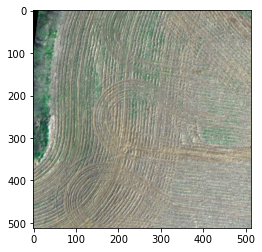

In [76]:
plt.imshow(x[2,:,:,1:])

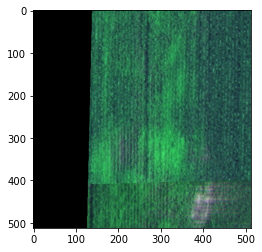

In [77]:
plt.imshow(x[0,:,:,1:])

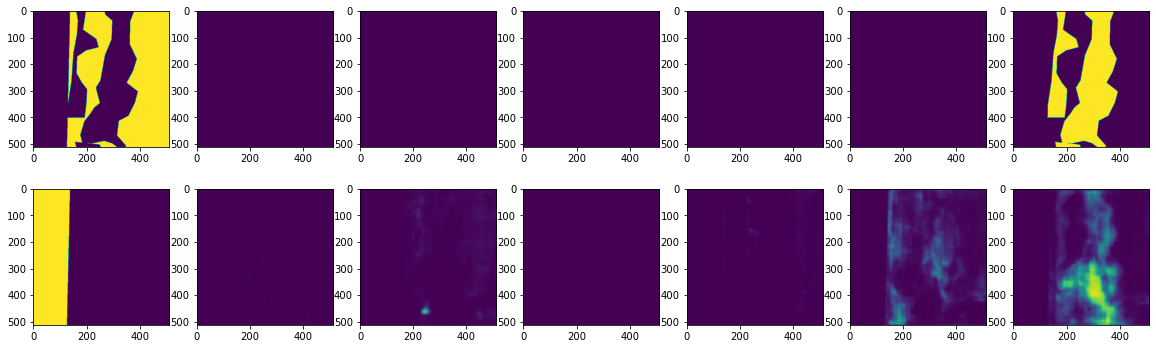

In [78]:
fig, axes = plt.subplots(2, 7, figsize=(20,6))
for i,ax in enumerate(axes.flat):
    if i <= 7: 
        ax.imshow(y[0,:,:, i])
    else:
        ax.imshow(y_pred[0,:,:,i % 7], vmin=0,vmax=1)

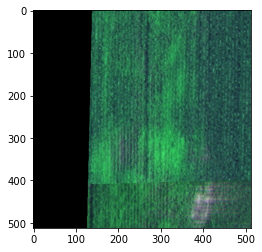

In [79]:
plt.imshow(x[0,:,:,1:])

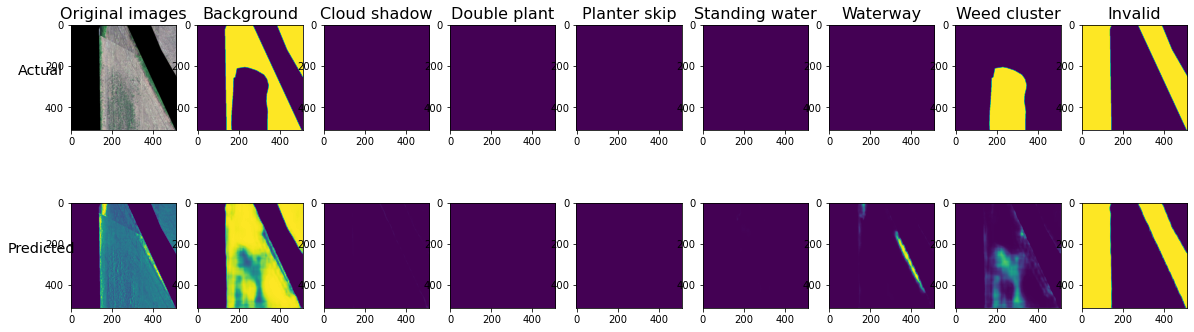

In [80]:
label_dict = ['Background','Cloud shadow', 'Double plant', 'Planter skip','Standing water','Waterway','Weed cluster','Invalid']
rows = ['{}'.format(row) for row in ['Actual','Predicted']]
num = 3
fig, axes = plt.subplots(2, 9, figsize=(20,6))
for i,ax in enumerate(axes.flat):
    if i == 0:
        ax.set_title('Original images',fontdict = {'fontsize' : 16})
        ax.imshow(x[num,:,:,1:])
    elif i == 9:
        ax.imshow(x[num,:,:,0])
    elif i < 9: 
        ax.imshow(y[num,:,:, i - 1])
        ax.set_title(label_dict[i - 1],fontdict = {'fontsize' : 16})
    else:
        ax.imshow(y_pred[num,:,:,(i-2) % 8], vmin=0,vmax=1)
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='x-large')

In [81]:
y_pred.shape

(4, 512, 512, 8)

In [ ]:
val_mIOU = AgrVimIOU(num_classes=7, per_classes=True)

for x, y in tqdm(iter(val_ds_final)):
    y_ = multi_predictor.predict(x)
    val_mIOU.update_state(y, y_)

943it [01:29, 11.04it/s]

In [112]:
val_mIOU.result()

[0.65689423918384793 0.0030339930424969925 0 0.0028129866725994375 0.054348104780477344 0.13947459202352325 0.36462438622194504]


<tf.Tensor: shape=(), dtype=float64, numpy=0.17445547170355571>

In [31]:
import pickle
pickle.dump(val_mIOU.result(),open('results.pkl','wb'))

[0.80289948863082006 0.0049310012179145293 0.18027836922273591 0.00091430521946372955 0.35192352027264073 0.32750912663734011 0.39513038264240746]


In [114]:
import pickle
pickle.load(open('results.pkl','rb'))

<tf.Tensor: shape=(), dtype=float64, numpy=0.2947980276919032>